Import bibliotek

In [519]:
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer # jedna klasa na trzy metody: "uniform", "quantile" i "kmeans"
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.discretisation import ArbitraryDiscretiser

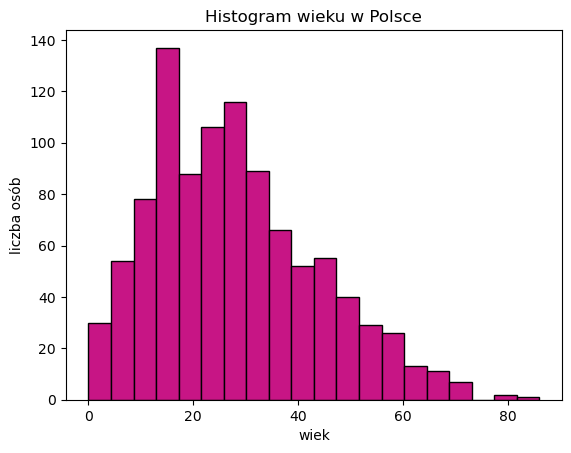

In [520]:
# Parametry beta – dobierają kształt rozkładu
a, b = 2, 5   # więcej młodych niż bardzo starych

# Generowanie 1000 wartości z rozkładu beta
wiek = beta.rvs(a, b, size=1000) * 100  # przeskalowanie na 0–100 lat

# Zaokrąglenie do pełnych lat
wiek = np.round(wiek).astype(int)

# histogram
plt.hist(wiek, bins=20, color="mediumvioletred", edgecolor='black') # density=True, żeby dostać gęstość
plt.title("Histogram wieku w Polsce")
plt.xlabel("wiek")
plt.ylabel("liczba osób")
plt.show()

In [521]:
# zrobimy df z tej array
df = pd.DataFrame({"wiek": wiek})

# Discretization

### Equal-width discretization with `pandas`

In [522]:
# chcemy mieć 10 przedziałów
n_bins = 10

width = round(((df["wiek"].max() - df["wiek"].min()) / n_bins),0) # min = 1, max = 79
width

9.0

`pd.cut()` zwraca Series, ale może też zwrócić `bins`, kiedy parametr `retbins=True`. Możemy też ustalić precyzję wyświetlania granic przedziałów w df.

In [523]:
# ale tutaj nie będziemy mieć granic przedziałów w intach, bo wychodzi przedział wartości 78, to daje nam 7,8 na przedział
df["wiek_pandas"], bins = pd.cut(df["wiek"], bins=10, precision=0, retbins=True, include_lowest=True, labels=False)
df, bins

(     wiek  wiek_pandas
 0      24            2
 1      17            1
 2      20            2
 3      55            6
 4      47            5
 ..    ...          ...
 995     7            0
 996    18            2
 997    65            7
 998    26            3
 999    47            5
 
 [1000 rows x 2 columns],
 array([-0.086,  8.6  , 17.2  , 25.8  , 34.4  , 43.   , 51.6  , 60.2  ,
        68.8  , 77.4  , 86.   ]))

In [524]:
# potrzebujemy zrobić bin edges do parametru bins w pd.cut()
# chcemy listę [0, 8, 16, ...]
bins = [i for i in np.arange(0, df["wiek"].max()+width, 8)]
df["wiek_pandas_ręcznie"] = pd.cut(df["wiek"], bins=bins)
df

,wiek,wiek_pandas,wiek_pandas_ręcznie
0,24,2,"(16.0, 24.0]"
1,17,1,"(16.0, 24.0]"
2,20,2,"(16.0, 24.0]"
3,55,6,"(48.0, 56.0]"
4,47,5,"(40.0, 48.0]"
...,...,...,...
995,7,0,"(0.0, 8.0]"
996,18,2,"(16.0, 24.0]"
997,65,7,"(64.0, 72.0]"
998,26,3,"(24.0, 32.0]"


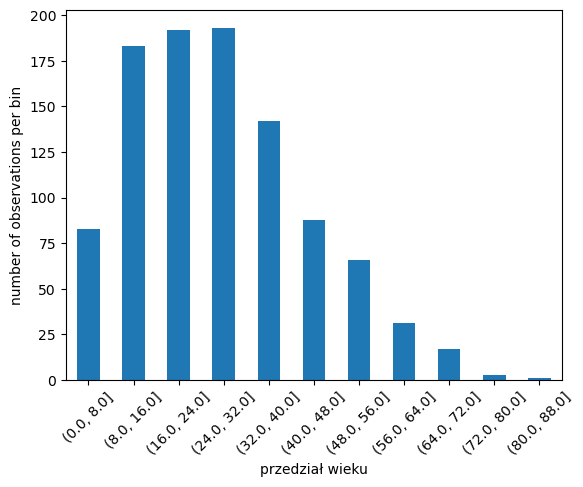

In [525]:
df.groupby("wiek_pandas_ręcznie", observed=False)["wiek_pandas_ręcznie"].count().plot.bar()
# observed: bool, default False
# This only applies if any of the groupers are Categoricals. 
# If True: only show observed values for categorical groupers. If False: show all values for categorical groupers.
plt.xticks(rotation=45)
plt.xlabel("przedział wieku")
plt.ylabel("number of observations per bin")
plt.show()

### Equal-width discretization with `sklearn`

In [526]:
discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")

In [527]:
discretizer.fit(df[["wiek"]])

,n_bins,10
,encode,'ordinal'
,strategy,'uniform'
,quantile_method,'warn'
,dtype,None
,subsample,200000
,random_state,None


In [528]:
df["wiek_sklearn"] = discretizer.transform(df[["wiek"]])
df["wiek_sklearn"].value_counts().sort_index()

wiek_sklearn
0.0     84
1.0    215
2.0    194
3.0    205
4.0    118
5.0     95
6.0     55
7.0     24
8.0      7
9.0      3
Name: count, dtype: int64

In [529]:
df

,wiek,wiek_pandas,wiek_pandas_ręcznie,wiek_sklearn
0,24,2,"(16.0, 24.0]",2.0
1,17,1,"(16.0, 24.0]",1.0
2,20,2,"(16.0, 24.0]",2.0
3,55,6,"(48.0, 56.0]",6.0
4,47,5,"(40.0, 48.0]",5.0
...,...,...,...,...
995,7,0,"(0.0, 8.0]",0.0
996,18,2,"(16.0, 24.0]",2.0
997,65,7,"(64.0, 72.0]",7.0
998,26,3,"(24.0, 32.0]",3.0


### Equal-width discretization with `feature-engine`

In [530]:
discretizer = EqualWidthDiscretiser(variables=["wiek"], bins=n_bins, precision=1)
discretizer.fit(df)
# okej, teraz by trzeba było zrobić kopię df, żeby nie nadpisywać nowych wartości w wyjściowej df

,variables,['wiek']
,bins,10
,return_object,False
,return_boundaries,False
,precision,1


# Equal-frequency discretization

### Equal-frequency discretization with `pandas`

In [531]:
# zrobimy nową df, żeby nazywać tak samo kolumny, jak wyżej
df = pd.DataFrame({"wiek": wiek})
df["wiek_pandas"], bins = pd.qcut(df["wiek"], q=10, precision=1, retbins=True)
df, bins

(     wiek   wiek_pandas
 0      24  (22.0, 26.0]
 1      17  (14.0, 18.0]
 2      20  (18.0, 22.0]
 3      55  (50.0, 86.0]
 4      47  (41.0, 50.0]
 ..    ...           ...
 995     7   (-0.1, 9.0]
 996    18  (14.0, 18.0]
 997    65  (50.0, 86.0]
 998    26  (22.0, 26.0]
 999    47  (41.0, 50.0]
 
 [1000 rows x 2 columns],
 array([ 0.,  9., 14., 18., 22., 26., 30., 35., 41., 50., 86.]))

In [532]:
df.groupby("wiek_pandas", observed=False)["wiek_pandas"].count().sort_index()

wiek_pandas
(-0.1, 9.0]     109
(9.0, 14.0]      97
(14.0, 18.0]    122
(18.0, 22.0]     88
(22.0, 26.0]     98
(26.0, 30.0]     95
(30.0, 35.0]    111
(35.0, 41.0]     84
(41.0, 50.0]     99
(50.0, 86.0]     97
Name: wiek_pandas, dtype: int64

In [533]:
# z powyższego widać, że musi być sporo osób w wieku 18 lat?
df[df["wiek"]==18].shape[0] # 28
df["wiek"].nunique() # 77 
df["wiek"].value_counts()

wiek
25    34
16    33
17    32
18    29
22    29
      ..
73     1
86     1
72     1
0      1
67     1
Name: count, Length: 75, dtype: int64

### Equal-frequency discretization with `sklearn`

In [534]:
discretiser = KBinsDiscretizer(encode="ordinal", strategy="quantile", n_bins=n_bins)
discretiser.fit(df[["wiek"]])

c:\Users\Joanna\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


,n_bins,10
,encode,'ordinal'
,strategy,'quantile'
,quantile_method,'warn'
,dtype,None
,subsample,200000
,random_state,None


In [535]:
df["wiek_sklearn"] = discretiser.transform(df[["wiek"]])
discretiser.bin_edges_

array([array([ 0.,  9., 14., 18., 22., 26., 30., 35., 41., 50., 86.])],
      dtype=object)

In [536]:
df

,wiek,wiek_pandas,wiek_sklearn
0,24,"(22.0, 26.0]",4.0
1,17,"(14.0, 18.0]",2.0
2,20,"(18.0, 22.0]",3.0
3,55,"(50.0, 86.0]",9.0
4,47,"(41.0, 50.0]",8.0
...,...,...,...
995,7,"(-0.1, 9.0]",0.0
996,18,"(14.0, 18.0]",3.0
997,65,"(50.0, 86.0]",9.0
998,26,"(22.0, 26.0]",5.0


### Equal-frequency discretization with `feature-engine`

In [537]:
discretiser = EqualFrequencyDiscretiser(variables=["wiek"], q=n_bins, return_object=True, return_boundaries=True)
# return_object=True -> zwrócone liczby będą stringami "object" type
# return_boundaries=True -> f True, it returns the interval boundaries. If False, it returns integers
discretiser.fit(df)

,variables,['wiek']
,q,10
,return_object,True
,return_boundaries,True
,precision,3


In [538]:
df_t = discretiser.transform(df) # bo inaczej zamieni wartości w kolumnie "wiek"
df_t

,wiek,wiek_pandas,wiek_sklearn
0,"(22.0, 26.0]","(22.0, 26.0]",4.0
1,"(14.0, 18.0]","(14.0, 18.0]",2.0
2,"(18.0, 22.0]","(18.0, 22.0]",3.0
3,"(50.0, inf]","(50.0, 86.0]",9.0
4,"(41.0, 50.0]","(41.0, 50.0]",8.0
...,...,...,...
995,"(-inf, 9.0]","(-0.1, 9.0]",0.0
996,"(14.0, 18.0]","(14.0, 18.0]",3.0
997,"(50.0, inf]","(50.0, 86.0]",9.0
998,"(22.0, 26.0]","(22.0, 26.0]",5.0


# Arbitrary discretisation
Możemy sami ustalić granice przedziałów, gdy ma to jakieś uzasadnienie w biznesie, np. kategorie wiekowe.

### Arbitrary discretisation with `pandas`

In [539]:
df = pd.DataFrame({"wiek": wiek})

# nowe bins
bins = [0, 18, 26, 40, 65, df["wiek"].max()]
labels = ["(0-18]", "(18-26]", "(26-40]", "(40-65]", "(65+)"]
df["wiek_pandas"] = pd.cut(df["wiek"], bins=bins, labels=labels, include_lowest=True, right=False)
df

,wiek,wiek_pandas
0,24,(18-26]
1,17,(0-18]
2,20,(18-26]
3,55,(40-65]
4,47,(40-65]
...,...,...
995,7,(0-18]
996,18,(18-26]
997,65,(65+)
998,26,(26-40]


C:\Users\Joanna\AppData\Local\Temp\ipykernel_19336\152426740.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby("wiek_pandas")["wiek"].count().sort_index()


<Axes: xlabel='wiek_pandas'>

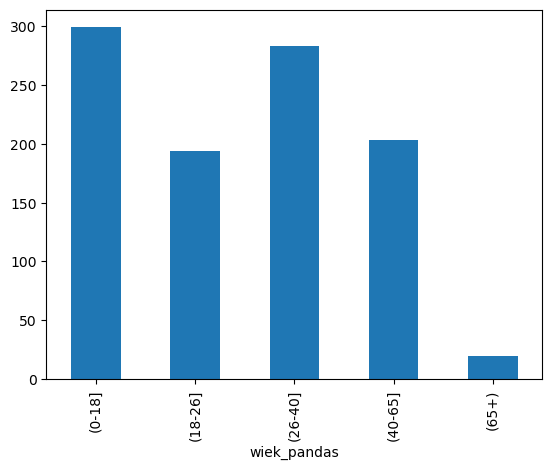

In [540]:
counts = df.groupby("wiek_pandas")["wiek"].count().sort_index()
counts.plot.bar()

### Nie ma implementacji arbitrary discretisation w `sklearn`

### Arbitrary discretisation in `feature-engine`

In [541]:
discretiser = ArbitraryDiscretiser(binning_dict={"wiek": bins}, return_object=True)
discretiser.fit(df)

,binning_dict,"{'wiek': [0, 18, ...]}"
,return_object,True
,return_boundaries,False
,precision,3
,errors,'ignore'


In [542]:
df_t = discretiser.transform(df)
df_t

,wiek,wiek_pandas
0,1,(18-26]
1,0,(0-18]
2,1,(18-26]
3,3,(40-65]
4,3,(40-65]
...,...,...
995,0,(0-18]
996,0,(18-26]
997,3,(65+)
998,1,(26-40]


# K-means discretisation - unsupervised
Dla `pandas` za skomplikowane.

### K-means discretisation in `sklearn`

In [543]:
df = pd.DataFrame({"wiek": wiek})

In [544]:
# ustalmy, że na 5 przedziałów chcemy podzielić
discretiser = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")
discretiser.fit(df[["wiek"]])

,n_bins,5
,encode,'ordinal'
,strategy,'kmeans'
,quantile_method,'warn'
,dtype,None
,subsample,200000
,random_state,None


In [545]:
df["wiek_sklearn"] = discretiser.transform(df[["wiek"]])
df

,wiek,wiek_sklearn
0,24,1.0
1,17,0.0
2,20,1.0
3,55,3.0
4,47,3.0
...,...,...
995,7,0.0
996,18,0.0
997,65,4.0
998,26,1.0


___
___
___

## Robimy `train_test_split`

In [579]:
df = pd.DataFrame({"wiek": wiek})
X_train, X_test = train_test_split(df["wiek"], test_size=0.3)

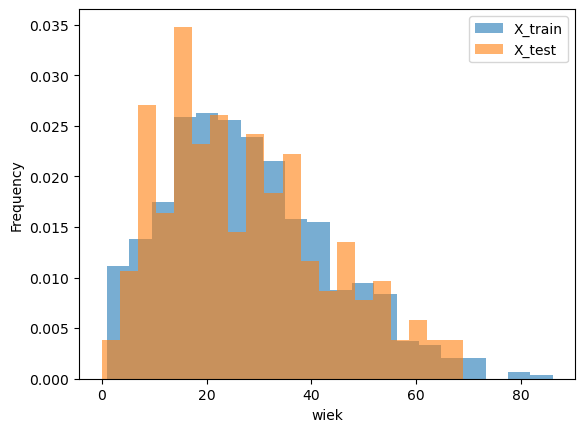

In [580]:
# zrobię sobie histogramy, żeby sobie poćwiczyć
X_train.plot.hist(alpha=0.6, density=True, bins=20, label="X_train")
X_test.plot.hist(alpha=0.6, density=True, bins=20, label="X_test")
plt.xlabel("wiek")
plt.legend()
plt.show()

In [581]:
# znowu k-means
# ustalmy, że na 5 przedziałów chcemy podzielić
discretiser = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans", subsample=None).set_output(transform="pandas")
discretiser.fit(np.array(X_train).reshape((-1,1)))

c:\Users\Joanna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,n_bins,5
,encode,'ordinal'
,strategy,'kmeans'
,quantile_method,'warn'
,dtype,None
,subsample,None
,random_state,None


In [582]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [583]:
X_train["wiek_disc"] = discretiser.transform(X_train)
X_test["wiek_disc"] = discretiser.transform(X_test)

c:\Users\Joanna\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KBinsDiscretizer was fitted without feature names
  warnings.warn(
c:\Users\Joanna\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KBinsDiscretizer was fitted without feature names
  warnings.warn(


In [584]:
X_train

,wiek,wiek_disc
543,59,4.0
723,24,1.0
157,46,3.0
548,25,1.0
41,35,2.0
...,...,...
414,48,3.0
425,28,1.0
115,29,1.0
972,26,1.0


<Axes: xlabel='wiek_disc'>

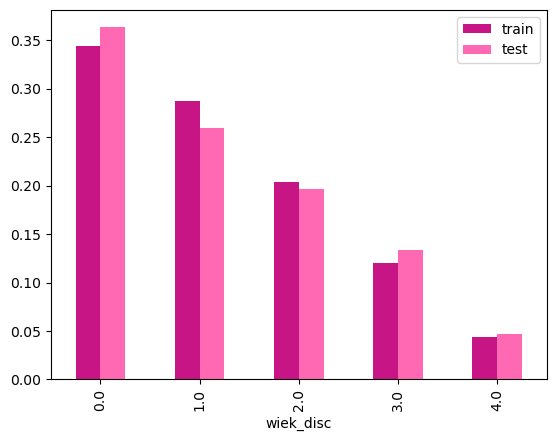

In [596]:
t1 = X_train.groupby("wiek_disc")["wiek"].count() / len(X_train) # odsetki policzone, bo różnoliczne sety
t2 = X_test.groupby("wiek_disc")["wiek"].count() / len(X_test)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ["train", "test"]
tmp.plot.bar(color={"train": "mediumvioletred", "test": "hotpink"})

Łoooo zgadza się 

# Discretisation with classification trees